In [2]:
import numpy as np

from scipy.optimize import curve_fit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit, DAGNode, DAGOpNode

import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

from tqdm import tqdm

from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow import Zero, One, I, X, Y, Z, SummedOp, PauliOp
from qiskit.circuit import Parameter, ParameterVector
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper



In [8]:
num_sites = 3
n_op = 0
for i in range(3):
    n_op += FermionicOp("+_"+str(i), register_length = 3) @ FermionicOp("-_"+str(i), register_length = 3)
        
jw_mapper = JordanWignerMapper
n_op_JW = [JordanWignerMapper.map(jw_mapper, n_op)]
n_op_JW

[PauliSumOp(SparsePauliOp(['III', 'IIZ', 'IZI', 'ZII'],
               coeffs=[ 1.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j]), coeff=1.0)]

In [10]:
n_is = [
    1 / 2 * ((I ^ num_sites) - ((I ^ i) ^ Z ^ (I ^ (num_sites - i - 1))))
    for i in range(num_sites)
    ]
n_is

[PauliSumOp(SparsePauliOp(['III', 'ZII'],
               coeffs=[ 0.5+0.j, -0.5+0.j]), coeff=1.0),
 PauliSumOp(SparsePauliOp(['III', 'IZI'],
               coeffs=[ 0.5+0.j, -0.5+0.j]), coeff=1.0),
 PauliSumOp(SparsePauliOp(['III', 'IIZ'],
               coeffs=[ 0.5+0.j, -0.5+0.j]), coeff=1.0)]

In [11]:
n_op_JW = []
for i in range(num_sites):
    n_op = FermionicOp("+_"+str(i), register_length = num_sites) @ FermionicOp("-_"+str(i), register_length = num_sites)
    jw_mapper = JordanWignerMapper
    n_op_JW.append(JordanWignerMapper.map(jw_mapper, n_op))

n_op_JW
    

[PauliSumOp(SparsePauliOp(['III', 'IIZ'],
               coeffs=[ 0.5+0.j, -0.5+0.j]), coeff=1.0),
 PauliSumOp(SparsePauliOp(['III', 'IZI'],
               coeffs=[ 0.5+0.j, -0.5+0.j]), coeff=1.0),
 PauliSumOp(SparsePauliOp(['III', 'ZII'],
               coeffs=[ 0.5+0.j, -0.5+0.j]), coeff=1.0)]

In [13]:
num_sites = 2
site1 = 0
site2 = 0
gamma_corr_1 = FermionicOp("-_"+str(site1), register_length = num_sites) + FermionicOp("+_"+str(site1), register_length = num_sites)
gamma_corr_2 = 1.0j * (FermionicOp("+_"+str(site2), register_length = num_sites) - FermionicOp("-_"+str(site2), register_length = num_sites))

gamma_corr = gamma_corr_1 @ gamma_corr_2

jw_mapper = JordanWignerMapper
gamma_corr_JW = [JordanWignerMapper.map(jw_mapper, gamma_corr)]
gamma_corr_JW

[PauliSumOp(SparsePauliOp(['IZ'],
               coeffs=[0.+1.j]), coeff=1.0)]

In [5]:
num_sites = 2
site1 = 0
n_op = FermionicOp("+_"+str(site1), register_length = num_sites) @ FermionicOp("-_"+str(site1), register_length = num_sites)

jw_mapper = JordanWignerMapper
n_op_JW = [JordanWignerMapper.map(jw_mapper, n_op)]
n_op_JW

[PauliSumOp(SparsePauliOp(['II', 'IZ'],
               coeffs=[ 0.5+0.j, -0.5+0.j]), coeff=1.0)]

In [17]:
def corr_op(num_sites, site1, site2):
    corr=FermionicOp("-_"+str(site1), register_length = num_sites)@FermionicOp("-_"+str(site2), register_length = num_sites)

    jw_mapper = JordanWignerMapper
    corr_JW = [JordanWignerMapper.map(jw_mapper, corr)]

    return corr_JW

def corr_dagger_op(num_sites, site1, site2):
    corr=FermionicOp("+_"+str(site1), register_length = num_sites)@FermionicOp("+_"+str(site2), register_length = num_sites)

    jw_mapper = JordanWignerMapper
    corr_JW = [JordanWignerMapper.map(jw_mapper, corr)]
    
    return corr_JW

print(corr_op(2,0,1))
print(corr_dagger_op(2,0,1))

[PauliSumOp(SparsePauliOp(['XY', 'YY', 'XX', 'YX'],
              coeffs=[ 0.  -0.25j,  0.25+0.j  , -0.25+0.j  ,  0.  -0.25j]), coeff=1.0)]
[PauliSumOp(SparsePauliOp(['XY', 'YY', 'XX', 'YX'],
              coeffs=[ 0.  -0.25j, -0.25+0.j  ,  0.25+0.j  ,  0.  -0.25j]), coeff=1.0)]


### 2-site Kitaev chain

In [3]:
def compute_H_secondquant_normal(eps, t, delta, num_sites):
    second_quant_H = 0
    for i in range(num_sites):
        second_quant_H += eps[i] * ( FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i)))

    for i in range(num_sites-1):

        second_quant_H += t * (FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i + 1)))
        second_quant_H += t * (FermionicOp("+_{}".format(i+1)) @ FermionicOp("-_{}".format(i)))

        second_quant_H += delta * (FermionicOp("+_{}".format(i)) @ FermionicOp("+_{}".format(i + 1)))
        second_quant_H += delta * (FermionicOp("-_{}".format(i + 1)) @ FermionicOp("-_{}".format(i)))

    # Transform to Pauli Operators
    jw_mapper = JordanWignerMapper
    pauli_H = JordanWignerMapper.map(jw_mapper, second_quant_H)

    return pauli_H

def compute_H_secondquant_nambu(eps, t, delta, num_sites):
    second_quant_H = 0
    for i in range(num_sites):
        second_quant_H += eps[i] / 2 * ( FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i)) - FermionicOp("-_{}".format(i)) @ FermionicOp("+_{}".format(i)) )
        second_quant_H += eps[i] / 2 * FermionicOp([("", 1)], register_length=num_sites)
        
    for i in range(num_sites-1):

        second_quant_H += t / 2 * (FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i + 1)) - FermionicOp("-_{}".format(i+1)) @ FermionicOp("+_{}".format(i)))
        second_quant_H += t / 2 * (FermionicOp("+_{}".format(i+1)) @ FermionicOp("-_{}".format(i)) - FermionicOp("-_{}".format(i)) @ FermionicOp("+_{}".format(i+1)) )

        second_quant_H += delta / 2 * (FermionicOp("+_{}".format(i)) @ FermionicOp("+_{}".format(i + 1)) - FermionicOp("+_{}".format(i+1)) @ FermionicOp("+_{}".format(i)))
        second_quant_H += delta / 2 * (FermionicOp("-_{}".format(i + 1)) @ FermionicOp("-_{}".format(i)) - FermionicOp("-_{}".format(i)) @ FermionicOp("-_{}".format(i+1)))

    # Transform to Pauli Operators
    jw_mapper = JordanWignerMapper
    pauli_H = JordanWignerMapper.map(jw_mapper, second_quant_H)

    return pauli_H

num_sites = 2
eps = np.ones(num_sites)
t = 1
delta = 2

H_normal = compute_H_secondquant_normal(eps, t, delta, num_sites)
print(f'Normal: {H_normal}')

H_nambu = compute_H_secondquant_nambu(eps, t, delta, num_sites)
print(f'Nambu: {H_nambu}')

Normal: 1.0 * II
- 0.5 * IZ
- 0.5 * ZI
- 0.5 * YY
+ 1.5 * XX
Nambu: 1.0 * II
- 0.5 * IZ
- 0.5 * ZI
- 0.5 * YY
+ 1.5 * XX


## 3-site Kitaev chain

In [4]:
def compute_H_secondquant_normal(eps, t, delta, num_sites):
    second_quant_H = 0
    for i in range(num_sites):
        second_quant_H += eps[i] * ( FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i)))

    for i in range(num_sites-1):

        second_quant_H += t * (FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i + 1)))
        second_quant_H += t * (FermionicOp("+_{}".format(i+1)) @ FermionicOp("-_{}".format(i)))

        second_quant_H += delta * (FermionicOp("+_{}".format(i)) @ FermionicOp("+_{}".format(i + 1)))
        second_quant_H += delta * (FermionicOp("-_{}".format(i + 1)) @ FermionicOp("-_{}".format(i)))

    # Transform to Pauli Operators
    jw_mapper = JordanWignerMapper
    pauli_H = JordanWignerMapper.map(jw_mapper, second_quant_H)

    return pauli_H

def compute_H_secondquant_nambu(eps, t, delta, num_sites):
    second_quant_H = 0
    for i in range(num_sites):
        second_quant_H += eps[i] / 2 * ( FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i)) - FermionicOp("-_{}".format(i)) @ FermionicOp("+_{}".format(i)) )
        second_quant_H += eps[i] / 2 * FermionicOp([("", 1)], register_length=num_sites)
        
    for i in range(num_sites-1):

        second_quant_H += t / 2 * (FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i + 1)) - FermionicOp("-_{}".format(i+1)) @ FermionicOp("+_{}".format(i)))
        second_quant_H += t / 2 * (FermionicOp("+_{}".format(i+1)) @ FermionicOp("-_{}".format(i)) - FermionicOp("-_{}".format(i)) @ FermionicOp("+_{}".format(i+1)) )

        second_quant_H += delta / 2 * (FermionicOp("+_{}".format(i)) @ FermionicOp("+_{}".format(i + 1)) - FermionicOp("+_{}".format(i+1)) @ FermionicOp("+_{}".format(i)))
        second_quant_H += delta / 2 * (FermionicOp("-_{}".format(i + 1)) @ FermionicOp("-_{}".format(i)) - FermionicOp("-_{}".format(i)) @ FermionicOp("-_{}".format(i+1)))

    # Transform to Pauli Operators
    jw_mapper = JordanWignerMapper
    pauli_H = JordanWignerMapper.map(jw_mapper, second_quant_H)

    return pauli_H

num_sites = 3
eps = np.ones(num_sites)
t = 1
delta = 2

H_normal = compute_H_secondquant_normal(eps, t, delta, num_sites)
print(f'Normal: {H_normal}')

H_nambu = compute_H_secondquant_nambu(eps, t, delta, num_sites)
print(f'Nambu: {H_nambu}')

Normal: 1.5 * III
- 0.5 * IIZ
- 0.5 * IZI
- 0.5 * ZII
- 0.5 * IYY
+ 1.5 * IXX
- 0.5 * YYI
+ 1.5 * XXI
Nambu: 1.5 * III
- 0.5 * IIZ
- 0.5 * IZI
- 0.5 * ZII
- 0.5 * IYY
+ 1.5 * IXX
- 0.5 * YYI
+ 1.5 * XXI


### Josephson Junction

In [5]:
def compute_H_secondquant_normal(eps, tc, t, delta):
    second_quant_H = 0
    second_quant_H += eps[0] * ( FermionicOp("+_{}".format(0)) @ FermionicOp("-_{}".format(0)))
    second_quant_H += eps[1] * ( FermionicOp("+_{}".format(1)) @ FermionicOp("-_{}".format(1)))    
    second_quant_H += t[0] * (FermionicOp("+_{}".format(0)) @ FermionicOp("-_{}".format(1)))
    second_quant_H += np.conjugate(t[0]) * (FermionicOp("+_{}".format(1)) @ FermionicOp("-_{}".format(0)))
    second_quant_H += delta[0] * (FermionicOp("+_{}".format(0)) @ FermionicOp("+_{}".format(1)))
    second_quant_H += np.conjugate(delta[0]) * (FermionicOp("-_{}".format(1)) @ FermionicOp("-_{}".format(0)))

    second_quant_H += tc * (FermionicOp("+_{}".format(2)) @ FermionicOp("-_{}".format(3)))
    second_quant_H += tc * (FermionicOp("+_{}".format(3)) @ FermionicOp("-_{}".format(2)))

    second_quant_H += eps[2] * ( FermionicOp("+_{}".format(2)) @ FermionicOp("-_{}".format(2)))
    second_quant_H += eps[3] * ( FermionicOp("+_{}".format(3)) @ FermionicOp("-_{}".format(3)))
    second_quant_H += t[1] * (FermionicOp("+_{}".format(2)) @ FermionicOp("-_{}".format(3)))
    second_quant_H += np.conjugate(t[1]) * (FermionicOp("+_{}".format(3)) @ FermionicOp("-_{}".format(2)))
    second_quant_H += delta[1] * (FermionicOp("+_{}".format(2)) @ FermionicOp("+_{}".format(3)))
    second_quant_H += np.conjugate(delta[1]) * (FermionicOp("-_{}".format(3)) @ FermionicOp("-_{}".format(2)))

    # Transform to Pauli Operators
    jw_mapper = JordanWignerMapper
    pauli_H = JordanWignerMapper.map(jw_mapper, second_quant_H)

    return pauli_H

def compute_H_secondquant_nambu(eps, tc,t, delta, num_sites):
    second_quant_H = 0
    # Firt couple
    second_quant_H += eps[0] / 2 * ( FermionicOp("+_{}".format(0)) @ FermionicOp("-_{}".format(0)) - FermionicOp("-_{}".format(0)) @ FermionicOp("+_{}".format(0)))
    second_quant_H += eps[1] / 2 * ( FermionicOp("+_{}".format(1)) @ FermionicOp("-_{}".format(1)) - FermionicOp("-_{}".format(1)) @ FermionicOp("+_{}".format(1)))
    second_quant_H += (eps[0]+eps[1]) / 2 * FermionicOp([("", 1)], register_length=num_sites)
    
    second_quant_H += t[0] / 2 * (FermionicOp("+_{}".format(0)) @ FermionicOp("-_{}".format(1)) - FermionicOp("-_{}".format(1)) @ FermionicOp("+_{}".format(0)))
    second_quant_H += np.conjugate(t[0]) / 2 * (FermionicOp("+_{}".format(1)) @ FermionicOp("-_{}".format(0))  - FermionicOp("-_{}".format(0)) @ FermionicOp("+_{}".format(1)) )
    
    second_quant_H += delta[0] / 2 * (FermionicOp("+_{}".format(0)) @ FermionicOp("+_{}".format(1))  - FermionicOp("+_{}".format(1)) @ FermionicOp("+_{}".format(0)))
    second_quant_H += np.conjugate(delta[0]) / 2 * (FermionicOp("-_{}".format(1)) @ FermionicOp("-_{}".format(0))  - FermionicOp("-_{}".format(0)) @ FermionicOp("-_{}".format(1)))
    # Bridge
    # second_quant_H += tc / 2 * (FermionicOp("+_{}".format(2)) @ FermionicOp("-_{}".format(3))  - FermionicOp("-_{}".format(3)) @ FermionicOp("+_{}".format(2)))
    # second_quant_H += tc / 2 * (FermionicOp("+_{}".format(3)) @ FermionicOp("-_{}".format(2))  - FermionicOp("-_{}".format(2)) @ FermionicOp("+_{}".format(3)))

    # Second couple
    second_quant_H += eps[2] / 2 * ( FermionicOp("+_{}".format(2)) @ FermionicOp("-_{}".format(2)) - FermionicOp("-_{}".format(2)) @ FermionicOp("+_{}".format(2)))
    second_quant_H += eps[3] / 2 * ( FermionicOp("+_{}".format(3)) @ FermionicOp("-_{}".format(3)) - FermionicOp("-_{}".format(3)) @ FermionicOp("+_{}".format(3)))
    second_quant_H += (eps[2]+eps[3]) / 2 * FermionicOp([("", 1)], register_length=num_sites)
    
    second_quant_H += t[1] / 2 * (FermionicOp("+_{}".format(2)) @ FermionicOp("-_{}".format(3)) - FermionicOp("-_{}".format(3)) @ FermionicOp("+_{}".format(2)))
    second_quant_H += np.conjugate(t[1]) / 2 * (FermionicOp("+_{}".format(3)) @ FermionicOp("-_{}".format(2))  - FermionicOp("-_{}".format(2)) @ FermionicOp("+_{}".format(3)) )
    
    second_quant_H += delta[1] / 2 * (FermionicOp("+_{}".format(2)) @ FermionicOp("+_{}".format(3))  - FermionicOp("+_{}".format(3)) @ FermionicOp("+_{}".format(2)))
    second_quant_H += np.conjugate(delta[1]) / 2 * (FermionicOp("-_{}".format(3)) @ FermionicOp("-_{}".format(2))  - FermionicOp("-_{}".format(2)) @ FermionicOp("-_{}".format(3)))
    
    # Transform to Pauli Operators
    jw_mapper = JordanWignerMapper
    pauli_H = JordanWignerMapper.map(jw_mapper, second_quant_H)

    return pauli_H

def compute_H(eps, t, delta, tc, phiL, phiR, num_sites):
    H = 0
    # On-site terms
    for i in range(num_sites):
        H += eps[i] / 2 * ((I ^ num_sites) - ((I ^ (num_sites - i - 1)) ^ Z ^ (I ^ i)))

    # Coupling term (qubits 2 and 1)
    H += tc / 2 * ((I ^ X ^ X ^ I) + (I ^ Y ^ Y ^ I))

    if np.array_equal(t,delta):
        H += 1 / 2 * np.cos(phiL*np.pi/180)*((I ^ I ^ X ^ X))
        H += 1 / 2 * np.cos(phiR*np.pi/180)*((X ^ X ^ I ^ I))
    else:
        #Left term
        H += t[0] / 2 * ((X ^ X ^ I ^ I) + (Y ^ Y ^ I ^ I))
        H += 1 / 2 * np.cos(phiL*np.pi/180)*((I ^ I ^ X ^ X) - (I ^ I ^ Y ^ Y))
        H += 1 / 2 * np.sin(phiL*np.pi/180)*((I ^ I ^ X ^ X) + (I ^ I ^ Y ^ Y))

        H += t[1] / 2 * ((I ^ I ^ X ^ X) + (I ^ I ^ Y ^ Y))
        H += 1 / 2 * np.cos(phiR*np.pi/180)*((X ^ X ^ I ^ I) - (Y ^ Y ^ I ^ I))
        H += 1 / 2 * np.sin(phiR*np.pi/180)*((X ^ X ^ I ^ I) + (Y ^ Y ^ I ^ I))
    

    return H




# Select specific t and t_c values

num_sites = 4
tc = 0.5
eps = np.ones(num_sites)
phi = 2*np.pi
phiL = -phi / 2
phiR = phi / 2
delta = np.array([np.exp(1j * phiL), np.exp(1j * phiR)])
t = np.ones(2)

H_normal = compute_H_secondquant_normal(eps, tc, t, delta)
print(f'Normal: {H_normal}')

H_nambu = compute_H_secondquant_nambu(eps, tc, t, delta, num_sites)
print(f'Nambu: {H_nambu}')

# Parameterized hopping strengths
eps_param = ParameterVector("ε", num_sites)
t_param = ParameterVector("t",2)
tc_param = Parameter("tc")
delta_param = ParameterVector("Δ",2)
phiL_param = Parameter("phiL")
phiR_param = Parameter("phiR")

H_param = compute_H(eps_param, t_param, delta_param, tc_param, phiL_param, phiR_param, num_sites)
H = H_param.bind_parameters({eps_param: eps, t_param: t, tc_param: tc, delta_param: delta, phiL_param:phiL, phiR_param:phiR})
print(f'Hardforce: {H}')

Normal: 2.0 * IIII
- 0.5 * IIIZ
- 0.5 * IIZI
+ 1.0 * IIYY
+ 1.25 * YYII
+ 0.25 * XXII
- 0.5 * IZII
- 0.5 * ZIII
Nambu: 2.0 * IIII
- 0.5 * IIIZ
- 0.5 * IIZI
+ 1.0 * IIYY
- 0.5 * IZII
- 0.5 * ZIII
+ 1.0 * YYII
Hardforce: SummedOp([
  0.5 * (
    1.0 * IIII
    - 1.0 * IIIZ
  ),
  0.5 * (
    1.0 * IIII
    - 1.0 * IIZI
  ),
  0.5 * (
    1.0 * IIII
    - 1.0 * IZII
  ),
  0.5 * (
    1.0 * IIII
    - 1.0 * ZIII
  ),
  0.25 * (
    1.0 * IXXI
    + 1.0 * IYYI
  ),
  0.5 * (
    1.0 * XXII
    + 1.0 * YYII
  ),
  0.4992485749319319 * (
    1.0 * IIXX
    - 1.0 * IIYY
  ),
  -0.027401832574394765 * (
    1.0 * IIXX
    + 1.0 * IIYY
  ),
  0.5 * (
    1.0 * IIXX
    + 1.0 * IIYY
  ),
  0.4992485749319319 * (
    1.0 * XXII
    - 1.0 * YYII
  ),
  0.027401832574394765 * (
    1.0 * XXII
    + 1.0 * YYII
  )
])


\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \gate{\mathrm{R_X}\,(\mathrm{\frac{\pi}{2}})} & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \ctrl{1} & \qw & \ctrl{1} & \gate{\mathrm{R_X}\,(\mathrm{\frac{-\pi}{2}})} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \gate{\mathrm{H}} & \qw & \qw & \qw & \qw & \qw & \ctrl{1} & \qw & \ctrl{1} & \gate{\mathrm{H}} & \gate{\mathrm{R_X}\,(\mathrm{\frac{\pi}{2}})} & \ctrl{1} & \qw & \ctrl{1} & \gate{\mathrm{R_X}\,(\mathrm{\frac{-\pi}{2}})} & \gate{\mathrm{R_X}\,(\mathrm{\frac{\pi}{2}})} & \targ & \gate{\mathrm{R_Z}\,(\mathrm{2\pi})} & \targ & \gate{\mathrm{R_X}\,(\mathrm{\frac{-\pi}{2}})} & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \gate{\mathrm{R_X}\,(\mathrm{\frac{\pi}{2}})} & \ctrl{1} & \qw & \ctrl{1

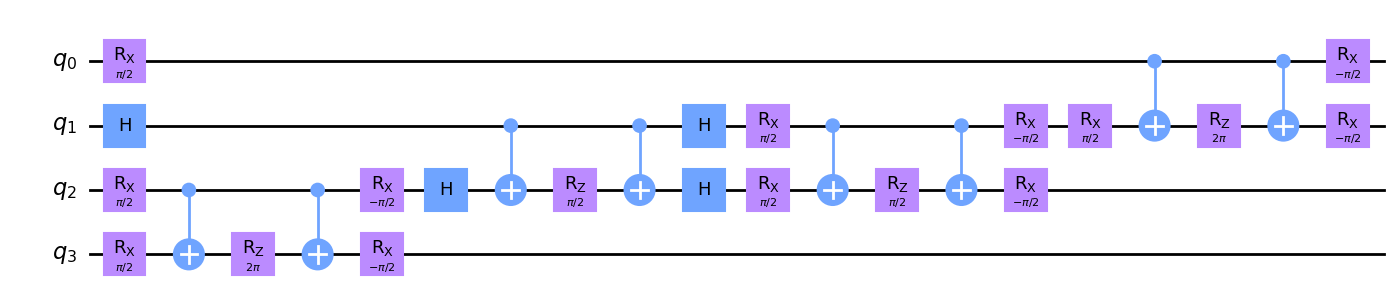

In [24]:
def compute_H_secondquant_normal(eps, tc, t, delta):
    second_quant_H = 0
    second_quant_H += eps * ( FermionicOp("+_{}".format(0)) @ FermionicOp("-_{}".format(0)))
    second_quant_H += t * (FermionicOp("+_{}".format(0)) @ FermionicOp("-_{}".format(1)))
    second_quant_H += np.conjugate(t) * (FermionicOp("+_{}".format(1)) @ FermionicOp("-_{}".format(0)))
    second_quant_H += delta[0] * (FermionicOp("+_{}".format(0)) @ FermionicOp("+_{}".format(1)))
    second_quant_H += np.conjugate(delta[0]) * (FermionicOp("-_{}".format(1)) @ FermionicOp("-_{}".format(0)))
    second_quant_H += eps * ( FermionicOp("+_{}".format(1)) @ FermionicOp("-_{}".format(1)))    

    second_quant_H += tc * (FermionicOp("+_{}".format(1)) @ FermionicOp("-_{}".format(2)))
    second_quant_H += tc * (FermionicOp("+_{}".format(2)) @ FermionicOp("-_{}".format(1)))

    second_quant_H += eps * ( FermionicOp("+_{}".format(2)) @ FermionicOp("-_{}".format(2)))
    second_quant_H += t * (FermionicOp("+_{}".format(2)) @ FermionicOp("-_{}".format(3)))
    second_quant_H += np.conjugate(t) * (FermionicOp("+_{}".format(3)) @ FermionicOp("-_{}".format(2)))
    second_quant_H += delta[1] * (FermionicOp("+_{}".format(2)) @ FermionicOp("+_{}".format(3)))
    second_quant_H += np.conjugate(delta[1]) * (FermionicOp("-_{}".format(3)) @ FermionicOp("-_{}".format(2)))
    second_quant_H += eps * ( FermionicOp("+_{}".format(3)) @ FermionicOp("-_{}".format(3)))

    # Transform to Pauli Operators
    jw_mapper = JordanWignerMapper
    pauli_H = JordanWignerMapper.map(jw_mapper, second_quant_H)

    return pauli_H

num_sites = 4
tc = 0.5
eps = 0
t = 1
phiR = phi / 2
delta_coff= 1

phi = 2*np.pi
phiL = -phi / 2
delta = np.array([delta_coff*np.exp(1j * phiL), delta_coff*np.exp(1j * phiR)])




from qiskit.opflow import PauliTrotterEvolution
from functions import compute_U_trot
def convert_U_trot_to_qc(U_trot):
    qc_trot = PauliTrotterEvolution().convert(U_trot)
    return (
        qc_trot.to_circuit().decompose().decompose()
    )  # add decompose methods so gates are not abstracted unitary blocks

H = compute_H_secondquant_normal(eps, tc, t, delta)
U1 = compute_U_trot(H, np.pi, 1)
qc = convert_U_trot_to_qc(U1)

latex_code = qc.draw("latex_source")
print(latex_code)
with open("circuits/JJ-circuit.tex", "w") as f:
    f.write(latex_code)
qc.draw("mpl")